In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# Data Loading and EDA

In [34]:
train_df = pd.read_csv("/kaggle/input/System-Threat-Forecaster/train.csv")
test_df  = pd.read_csv("/kaggle/input/System-Threat-Forecaster/test.csv")

In [35]:
train_df.shape

(100000, 76)

In [36]:
test_df.shape

(10000, 75)

In [37]:
train_df.head()

,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,...,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,DateAS,DateOS,target
0,f541bae429089117c4aac39c90dd3416,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1003.0,0,7.0,0,53447.0,1.0,...,0,0.0,1,0,1.0,0.0,6.0,2018-09-10 10:11:00,2018-04-17,0
1,dc2b14d9ce3a0ce4050bb640190f2ca5,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1465.0,0,7.0,0,53447.0,1.0,...,1,0.0,0,0,0.0,0.0,10.0,2018-08-16 00:01:00,2018-08-14,1
2,fd20c5f010e9c5f91ad1c6b3e0da68a0,win8defender,1.1.15200.1,4.18.1807.18075,1.275.1546.0,0,7.0,0,53447.0,1.0,...,0,0.0,0,0,0.0,1.0,6.0,2018-09-20 23:20:00,2018-09-11,1
3,38711eae85eb77a72ec5dfdf27eb2a76,win8defender,1.1.15200.1,4.12.17007.18011,1.275.1141.0,0,7.0,0,46413.0,2.0,...,1,0.0,0,0,0.0,0.0,12.0,2018-09-14 00:32:00,2018-01-03,1
4,32607c9a543a9214e2c7e45800ed4849,win8defender,1.1.15200.1,4.13.17134.228,1.275.1283.0,0,7.0,0,40466.0,2.0,...,0,0.0,0,0,0.0,1.0,7.0,2018-09-15 19:34:00,2018-09-11,0


In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     

In [39]:
train_df.describe()

,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,HasTpm,CountryID,CityID,GeoRegionID,...,FirmwareManufacturerID,FirmwareVersionID,IsSecureBootEnabled,IsVirtualDevice,IsTouchEnabled,IsPenCapable,IsAlwaysOnAlwaysConnectedCapable,IsGamer,RegionIdentifier,target
count,100000.0,99934.000000,100000.000000,99924.000000,99924.000000,99924.000000,100000.000000,100000.000000,99377.000000,100000.000000,...,99624.000000,99666.000000,100000.000000,99980.000000,100000.000000,100000.000000,99866.000000,99441.000000,99441.000000,100000.000000
mean,0.0,6.848430,0.017620,47975.710440,1.326528,1.018264,0.996780,108.078790,81029.938587,169.741630,...,401.987613,32942.648044,0.495690,0.003841,0.128470,0.040580,0.058398,0.296668,7.875866,0.505250
std,0.0,1.015166,0.131566,13803.321533,0.520681,0.155291,0.056654,63.062151,48944.027074,89.188929,...,221.318891,21151.970827,0.499984,0.061855,0.334614,0.197316,0.234496,0.456791,4.562533,0.499975
min,0.0,0.000000,0.000000,39.000000,1.000000,0.000000,0.000000,1.000000,7.000000,1.000000,...,2.000000,121.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.0,7.000000,0.000000,49480.000000,1.000000,1.000000,1.000000,51.000000,36694.000000,89.000000,...,142.000000,13020.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,0.0,7.000000,0.000000,53447.000000,1.000000,1.000000,1.000000,97.000000,82373.000000,181.000000,...,500.000000,33066.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,1.000000
75%,0.0,7.000000,0.000000,53447.000000,2.000000,1.000000,1.000000,162.000000,122835.000000,267.000000,...,556.000000,52357.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,1.000000
max,0.0,8.000000,1.000000,70490.000000,5.000000,4.000000,1.000000,222.000000,167957.000000,296.000000,...,1083.000000,72091.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,1.000000


In [40]:
# Check for missing values
train_df.isnull().sum()

MachineID             0
ProductName           0
EngineVersion         0
AppVersion            0
SignatureVersion      0
                   ... 
IsGamer             559
RegionIdentifier    559
DateAS                0
DateOS               24
target                0
Length: 76, dtype: int64

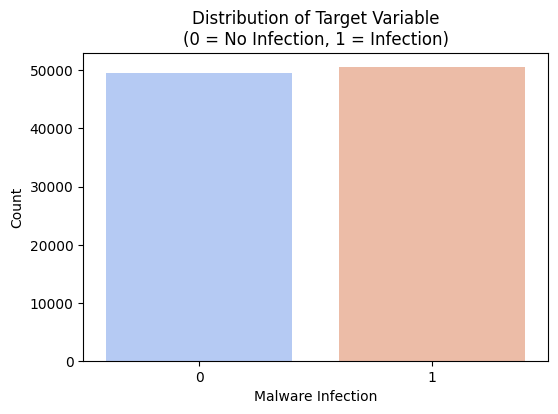

In [41]:
# --- Target Distribution ---
plt.figure(figsize=(6, 4))
sns.countplot(x=train_df["target"], palette="coolwarm")
plt.title("Distribution of Target Variable\n(0 = No Infection, 1 = Infection)")
plt.xlabel("Malware Infection")
plt.ylabel("Count")
plt.show()


**The target variable (malware infection) is nearly balanced, with slightly more “Infection” (1) cases than “No Infection” (0) cases . This indicates there isn’t a severe class imbalance in the dataset.Since the dataset is roughly split between 0 and 1, standard classification metrics (accuracy, precision, recall) remain appropriate.**


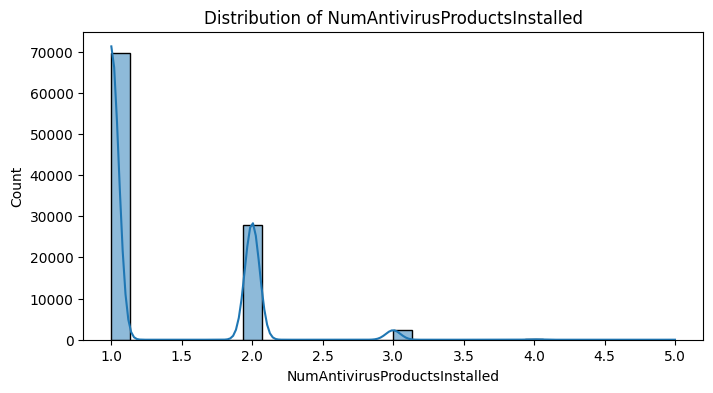

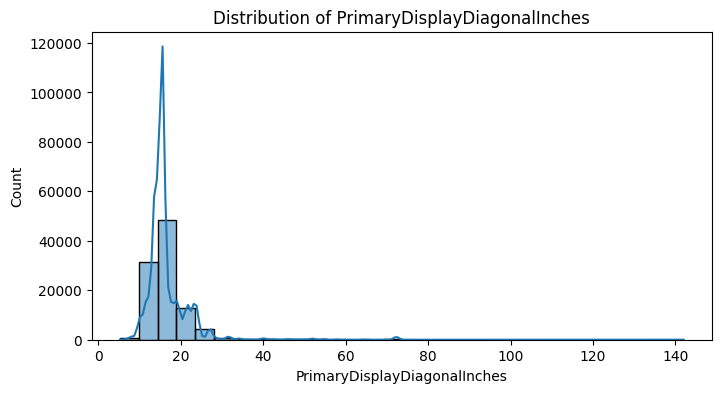

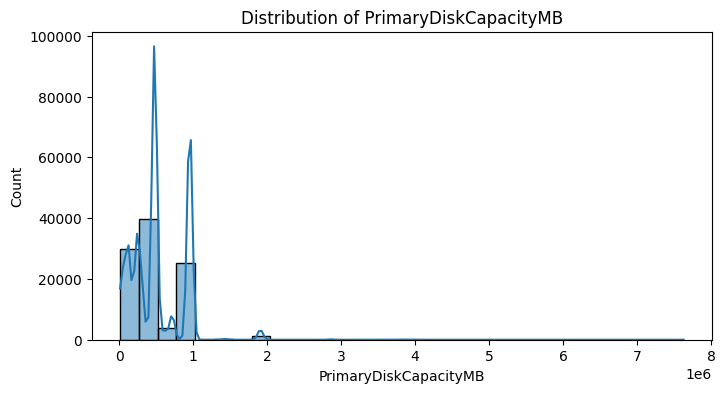

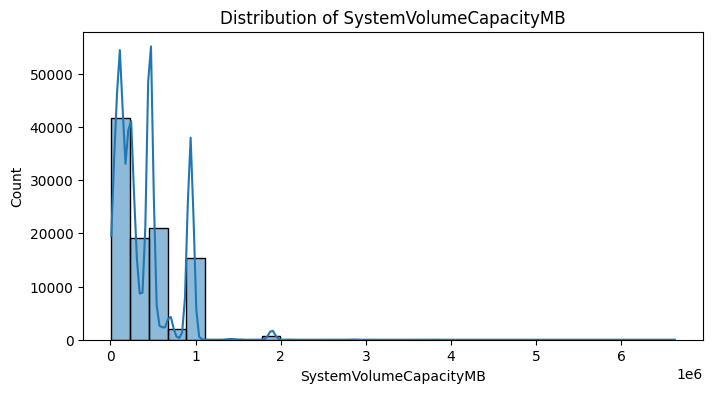

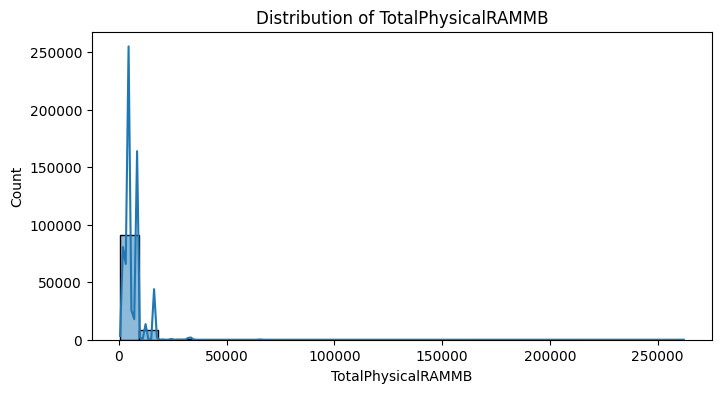

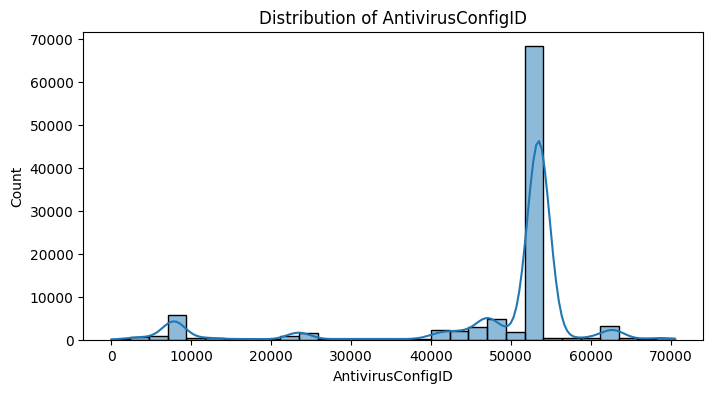

In [42]:
# Visualize numerical columns
numerical_columns = ['NumAntivirusProductsInstalled', 'PrimaryDisplayDiagonalInches',
    'PrimaryDiskCapacityMB', 'SystemVolumeCapacityMB', 'TotalPhysicalRAMMB','AntivirusConfigID']

for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()


* NumAntivirusProductsInstalled - The distribution is heavily skewed , with the majority of machines having only 1 antivirus product installed, a notable cluster around 2, and very few machines having 3 or more.
  
* PrimaryDisplayDiagonalInches - There’s a large spike around typical laptop/monitor sizes (e.g., 13–15 inches), with a long tail extending out to very large values (over 100 inches)

  
* PrimaryDiskCapacityMB - Highly skewed, with clusters around typical hard drive/SSD capacities (hundreds of GB), but also extending to 1 TB or more. A small number of machines have very large disk capacities in the multiple terabyte range.

  
* TotalPhysicalRAMMB - Most devices have a few gigabytes of RAM (e.g., 4–16 GB), but some go up to 128 GB or more, creating a long tail.

  
* AntivirusConfigID - Numeric ID with multiple peaks, suggesting distinct configuration types. One large peak around ~50,000, indicating a dominant configuration, with smaller clusters at other ID ranges.
The dominant category (the large peak) could mean many machines share a common antivirus configuration. Other less common configurations might correlate with higher or lower infection rates.
  

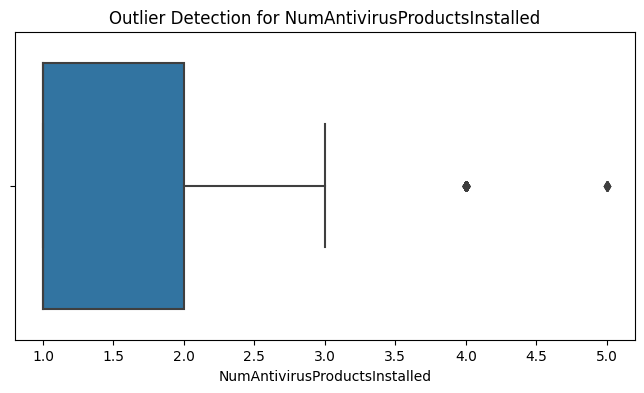

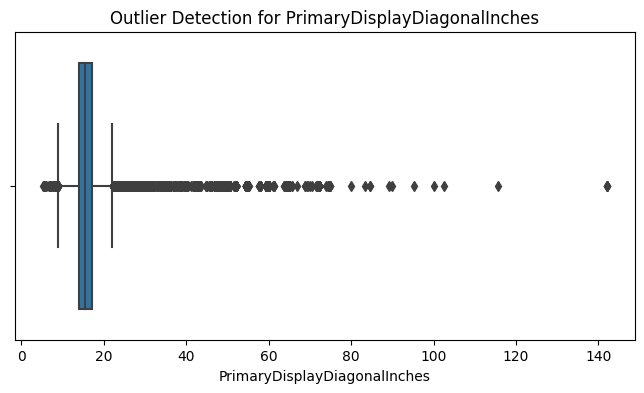

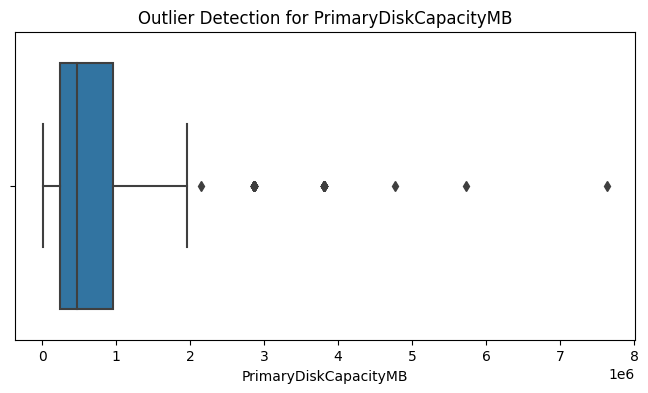

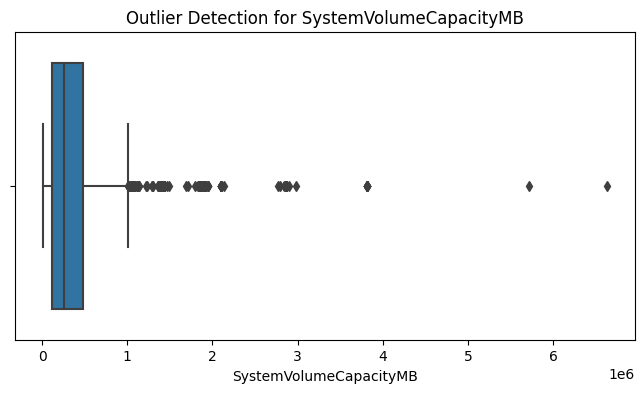

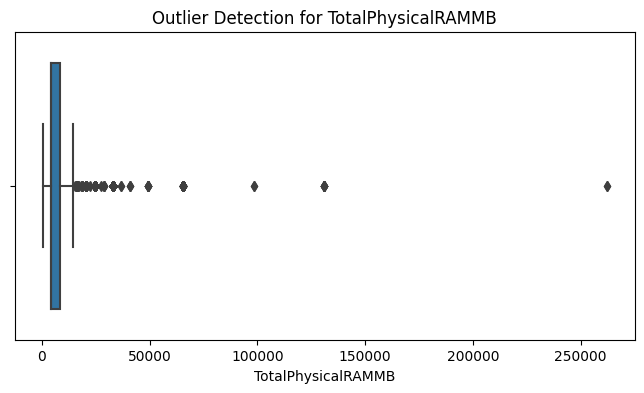

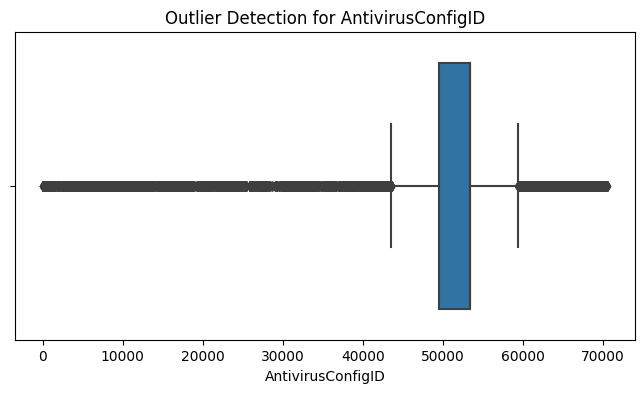

In [43]:
# Checking for Outlier 

for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train_df[col])
    plt.title(f"Outlier Detection for {col}")
    plt.show()

Each of the examined variables exhibits notable outliers, indicating heavily skewed distributions or extreme values. For instance, NumAntivirusProductsInstalled mostly clusters around 1–2 but extends to 4–5

Meanwhile, AntivirusConfigID, though numeric, likely represents a categorical ID and also has a pronounced concentration at higher values
The outlier will affect model performance , leading to bias and skewed

AntivirusConfigID, the numbers are used as labels (codes) for different antivirus configurations rather than representing a continuous or ordered quantity. This means that the magnitude of the number doesn't have a meaningful order. Thus, even though it appears numeric, it's often more appropriate to treat it as a categorical variable, using encoding techniques rather than numeric scaling.

# FEATURE ENGINEERING: DATE COLUMNS

In [44]:
# Convert date columns and extract new features for both train and test

for df in [train_df, test_df]:
    df['DateAS'] = pd.to_datetime(df['DateAS'], errors='coerce')
    df['DateOS'] = pd.to_datetime(df['DateOS'], errors='coerce')
    
    # DateAS features
    df['DateAS_year']    = df['DateAS'].dt.year
    df['DateAS_month']   = df['DateAS'].dt.month
    df['DateAS_day']     = df['DateAS'].dt.day
    df['DateAS_weekday'] = df['DateAS'].dt.weekday

    # DateOS features
    df['DateOS_year']    = df['DateOS'].dt.year
    df['DateOS_month']   = df['DateOS'].dt.month
    df['DateOS_day']     = df['DateOS'].dt.day
    df['DateOS_weekday'] = df['DateOS'].dt.weekday

    # Remove original date columns
    df.drop(['DateAS', 'DateOS'], axis=1, inplace=True)

# DATA PREPARATION & PREPROCESSING

In [45]:
X = train_df.drop(['MachineID', 'target'], axis=1)
y = train_df['target']
X_test = test_df.drop(['MachineID'], axis=1)


In [46]:
X_test.head()

,ProductName,EngineVersion,AppVersion,SignatureVersion,IsBetaUser,RealTimeProtectionState,IsPassiveModeEnabled,AntivirusConfigID,NumAntivirusProductsInstalled,NumAntivirusProductsEnabled,...,IsGamer,RegionIdentifier,DateAS_year,DateAS_month,DateAS_day,DateAS_weekday,DateOS_year,DateOS_month,DateOS_day,DateOS_weekday
0,win8defender,1.1.15100.1,4.18.1807.18075,1.273.1276.0,0,7.0,0,53447.0,1.0,1.0,...,1.0,11.0,2018,8,12,6,2018.0,7.0,10.0,1.0
1,win8defender,1.1.15100.1,4.10.209.0,1.273.371.0,0,7.0,0,46184.0,2.0,2.0,...,0.0,12.0,2018,7,26,3,2016.0,10.0,11.0,1.0
2,win8defender,1.1.15200.1,4.18.1807.18075,1.275.263.0,0,7.0,0,51954.0,2.0,1.0,...,0.0,10.0,2018,8,27,0,2018.0,5.0,8.0,1.0
3,win8defender,1.1.15300.6,4.18.1807.18075,1.277.58.0,0,7.0,0,41571.0,2.0,1.0,...,0.0,10.0,2018,9,25,1,2018.0,5.0,8.0,1.0
4,win8defender,1.1.14800.3,4.14.17639.18041,1.267.898.0,0,7.0,0,40645.0,3.0,1.0,...,0.0,7.0,2018,5,6,6,2018.0,6.0,12.0,1.0


In [47]:
# Define categorical and numeric features
categorical_features = [
    'ProductName','EngineVersion','AppVersion','SignatureVersion','IsBetaUser',
    'RealTimeProtectionState','IsPassiveModeEnabled','AntivirusConfigID','CountryID',
    'CityID','GeoRegionID','LocaleEnglishNameID','PlatformType','Processor','OSVersion',
    'OsPlatformSubRelease','OSBuildLab','SKUEditionName','IsSystemProtected',
    'AutoSampleSubmissionEnabled','SMode','IEVersionID','FirewallEnabled','EnableLUA',
    'MDC2FormFactor','DeviceFamily','OEMNameID','OEMModelID','ProcessorManufacturerID',
    'ProcessorModelID','PrimaryDiskType','HasOpticalDiskDrive','ChassisType',
    'PowerPlatformRole','OSArchitecture','OSBranch','OSEdition','OSSkuFriendlyName',
    'OSInstallType','AutoUpdateOptionsName','OSGenuineState','LicenseActivationChannel',
    'IsFlightsDisabled','FlightRing','FirmwareManufacturerID','FirmwareVersionID',
    'IsSecureBootEnabled','IsVirtualDevice','IsTouchEnabled','IsPenCapable',
    'IsAlwaysOnAlwaysConnectedCapable','IsGamer','RegionIdentifier','OSInstallLanguageID',
    'OSUILocaleID','DateAS_month','DateAS_weekday','DateOS_month','DateOS_weekday','NumericOSVersion'
]

numeric_features = [
    'NumAntivirusProductsInstalled','NumAntivirusProductsEnabled','OSBuildNumber','OSProductSuite',
    'ProcessorCoreCount','PrimaryDiskCapacityMB','SystemVolumeCapacityMB','TotalPhysicalRAMMB',
    'PrimaryDisplayDiagonalInches','PrimaryDisplayResolutionHorizontal','PrimaryDisplayResolutionVertical',
    'InternalBatteryNumberOfCharges','OSBuildNumberOnly','OSBuildRevisionOnly','DateAS_year','DateOS_year'
]


In [48]:
# Split categorical features into low and high cardinality (threshold = 10 unique values)
low_cardinality = []
high_cardinality = []
for col in categorical_features:
    if X[col].astype(str).nunique() <= 10:
        low_cardinality.append(col)
    else:
        high_cardinality.append(col)

# Transformer to convert to string (useful for encoding)
to_string = FunctionTransformer(lambda x: x.astype(str))

# Pipeline for numeric features: imputation and scaling
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline for low-cardinality categorical features: imputation and one-hot encoding
low_cat_pipeline = Pipeline(steps=[
    ('to_string', to_string),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline for high-cardinality categorical features: imputation and ordinal encoding
high_cat_pipeline = Pipeline(steps=[
    ('to_string', to_string),
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine pipelines with ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('low_cat', low_cat_pipeline, low_cardinality),
    ('high_cat', high_cat_pipeline, high_cardinality)
])


In [49]:
# Fit preprocessor on training data and transform both train and test sets
X_transformed = preprocessor.fit_transform(X)
X_test_transformed = preprocessor.transform(X_test)

# Train-Test Split & Evaluation Function

In [50]:
X_train, X_val, y_train, y_val = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42, stratify=y
)

def train_evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    return model, accuracy

#                       ------ Baseline Models ------------- 

# Logistic Regression

In [51]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
acc_log_reg = train_evaluate_model(log_reg, "Logistic Regression")

Logistic Regression Accuracy: 0.5471


# Random Forest

In [52]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
acc_rf = train_evaluate_model(rf, "Random Forest")

Random Forest Accuracy: 0.6173


# XG Boost

In [53]:
xgb_clf = xgb.XGBClassifier(n_estimators=100, max_depth=10, random_state=42,
                            use_label_encoder=False, eval_metric='logloss')
acc_xgb = train_evaluate_model(xgb_clf, "XGBoost")


XGBoost Accuracy: 0.6071


# LGBM

In [54]:
lgb_clf = lgb.LGBMClassifier(n_estimators=100, max_depth=10, random_state=42)
acc_lgb = train_evaluate_model(lgb_clf, "LightGBM")

[LightGBM] [Info] Number of positive: 40420, number of negative: 39580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4553
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505250 -> initscore=0.021001
[LightGBM] [Info] Start training from score 0.021001
LightGBM Accuracy: 0.6311


# HYPERPARAMETER TUNING 

In [55]:
def hyperparameter_tuning(model, param_grid, model_name):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy',
                               n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{model_name} Tuned Accuracy: {accuracy:.4f}")
    return best_model, accuracy

Random Forest Tuning 

In [56]:
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_tuned, acc_rf_tuned = hyperparameter_tuning(RandomForestClassifier(random_state=42),
                                               param_grid_rf, "Random Forest")

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Random Forest Tuned Accuracy: 0.6226


XG-Boost Tuning 

In [63]:
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'learning_rate': [0.1, 0.01]
}
xgb_tuned, acc_xgb_tuned = hyperparameter_tuning(xgb.XGBClassifier(random_state=42,
                                                                    use_label_encoder=False,
                                                                    eval_metric='logloss'),
                                                 param_grid_xgb, "XGBoost")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
XGBoost Tuned Accuracy: 0.6286


LGBM Tuning

In [ ]:
param_grid_lgb = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'learning_rate': [0.1, 0.01]
}
lgb_tuned, acc_lgb_tuned = hyperparameter_tuning(lgb.LGBMClassifier(random_state=42),
                                                 param_grid_lgb, "LightGBM")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 40420, number of negative: 39580
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4553
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 169
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505250 -> initscore=0.021001
[LightGBM] [Info] Start training from score 0.021001


# Stacking Classifier

In [ ]:
estimators = [
    ('rf', rf_tuned),
    ('xgb', xgb_tuned),
    ('lgb', lgb_tuned)
]
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=3,
    n_jobs=-1
)
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_val)
acc_stack = accuracy_score(y_val, y_pred_stack)
print(f"\nStacking Classifier Accuracy: {acc_stack:.4f}")

**Submission CSV**

In [ ]:
def submit(test_df, test_predictions, filename='submission.csv'):
    submission = pd.DataFrame({
        'id': range(0, test_df.shape[0]),
        'target': test_predictions
    })
    submission['target'] = submission['target']
    submission.to_csv(filename, index=False)


test_predictions=stacking_clf.predict(X_test_transformed )
submit(test_df, test_predictions, filename='submission.csv')

# Model Comparison

In [ ]:
# Logistic Regression (Baseline) = 0.5471
# Random Forest (Baseline) = 0.6173
# XGBoost (Baseline)= 0.6071
# LightGBM (Baseline) = 0.6311
# Random Forest (Tuned)= 0.6226
# XGBoost (Tuned) = 0.6286
# LightGBM (Tuned) = 0.6311
# Stacking Classifier = 0.6314

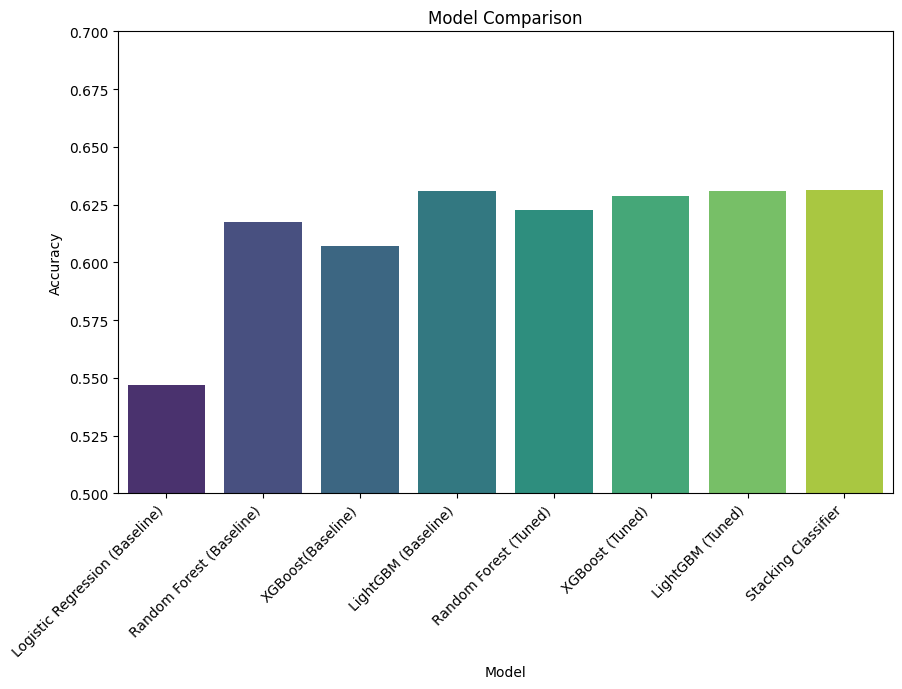

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

models = ['Logistic Regression (Baseline)','Random Forest (Baseline)' ,'XGBoost(Baseline)','LightGBM (Baseline)','Random Forest (Tuned)','XGBoost (Tuned)','LightGBM (Tuned)','Stacking Classifier']

accuracies = [0.5471,0.6173,0.6071,0.6311,0.6226,0.6286,0.6311,0.6314]

data = {'Model': models, 'Accuracy': accuracies}
df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis')
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.5, 0.7)  
plt.xticks(rotation=45, ha='right')  
plt.show()